# Isprobavanje binary classifiera

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

In [ ]:
# Access to uploaded files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_prefix = 'drive/My Drive/Colab Notebooks/Diplomski'
attrs = ['crown', 'endofilling', 'filling', 'bridge']

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = dict()
dataloaders = dict()
dataset_sizes = dict()
class_names = dict()


for attr in attrs:
  data_dir = f'{dir_prefix}/{attr}_dataset'
  image_datasets[attr] = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                    for x in ['train', 'val']}
  dataloaders[attr] = {x: torch.utils.data.DataLoader(image_datasets[attr][x], batch_size=4,
                                              shuffle=True, num_workers=4)
                for x in ['train', 'val']}
  dataset_sizes[attr] = {x: len(image_datasets[attr][x]) for x in ['train', 'val']}
  class_names[attr] = image_datasets[attr]['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(class_names)

{'crown': ['no', 'yes'], 'endofilling': ['no', 'yes'], 'filling': ['no', 'yes'], 'bridge': ['no', 'yes']}


Showing images of crown:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


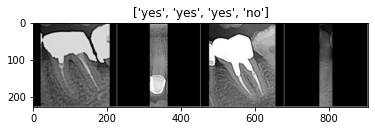

Showing images of endofilling:


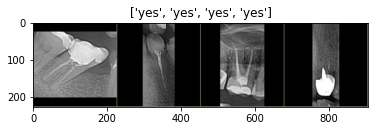

Showing images of filling:


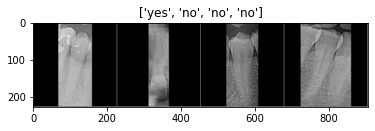

Showing images of bridge:


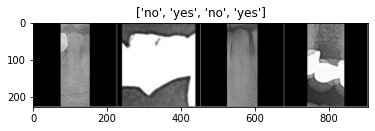

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

for attr in attrs:
  print(f'Showing images of {attr}:')
  # Get a batch of training data
  inputs, classes = next(iter(dataloaders[attr]['train']))

  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[attr][x] for x in classes])



In [ ]:
def train_model(model, criterion, optimizer, scheduler, attr, num_epochs=25):
    print(f'Training a model on {attr} label.')
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[attr][phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[attr][phase]
            epoch_acc = running_corrects.double() / dataset_sizes[attr][phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc on {}: {:4f}'.format(attr, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
i = 0
for inputs, labels in dataloaders['filling']['val']:
  print(f'{labels}')
  i += 1
  if i == 5: break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1, 0, 1, 0])
tensor([1, 0, 1, 1])
tensor([1, 1, 1, 0])
tensor([1, 1, 0, 1])
tensor([0, 0, 0, 0])


In [ ]:
def visualize_model(model, attr, num_images=6):
    print(f'Visualizing model for {attr} dataset.')
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[attr]['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[attr][preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
trained_models = dict()

for attr in attrs:
  print(f'Training model for {attr}')
  model_ft = models.resnet18(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  # Here the size of each output sample is set to 2.
  # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
  model_ft.fc = nn.Linear(num_ftrs, 2)

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        attr=attr, num_epochs=15)
  print()
  trained_models[attr] = model_ft

Training model for crown
Training a model on crown label.
Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4455 Acc: 0.8186
val Loss: 0.2476 Acc: 0.9404

Epoch 1/14
----------
train Loss: 0.3477 Acc: 0.8863
val Loss: 0.1631 Acc: 0.9533

Epoch 2/14
----------
train Loss: 0.2459 Acc: 0.9183
val Loss: 0.1469 Acc: 0.9474

Epoch 3/14
----------
train Loss: 0.1709 Acc: 0.9399
val Loss: 0.1645 Acc: 0.9509

Epoch 4/14
----------
train Loss: 0.0922 Acc: 0.9699
val Loss: 0.1701 Acc: 0.9591

Epoch 5/14
----------
train Loss: 0.0745 Acc: 0.9744
val Loss: 0.1908 Acc: 0.9486

Epoch 6/14
----------
train Loss: 0.0731 Acc: 0.9790
val Loss: 0.1945 Acc: 0.9474

Epoch 7/14
----------
train Loss: 0.0266 Acc: 0.9935
val Loss: 0.1493 Acc: 0.9544

Epoch 8/14
----------
train Loss: 0.0230 Acc: 0.9935
val Loss: 0.1639 Acc: 0.9603

Epoch 9/14
----------
train Loss: 0.0168 Acc: 0.9970
val Loss: 0.1538 Acc: 0.9579

Epoch 10/14
----------
train Loss: 0.0132 Acc: 0.9975
val Loss: 0.1603 Acc: 0.9614

Epoch 11/14
----------
train Loss: 0.0097 Acc: 0.9990
val Loss: 0.1547 Acc: 0.9603

Epoch 12/14
----------
t

Visualizing model for crown dataset.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


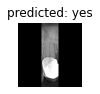

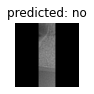

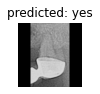

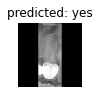

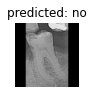

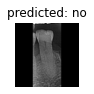

Visualizing model for endofilling dataset.


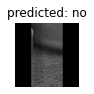

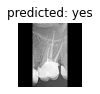

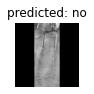

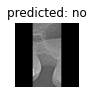

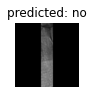

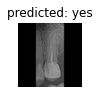

Visualizing model for filling dataset.


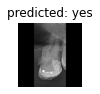

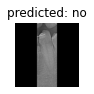

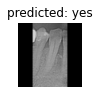

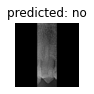

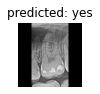

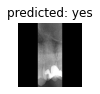

Visualizing model for bridge dataset.


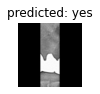

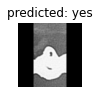

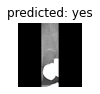

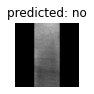

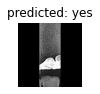

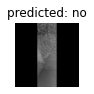

In [ ]:
for attr in attrs:
  visualize_model(trained_models[attr], attr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

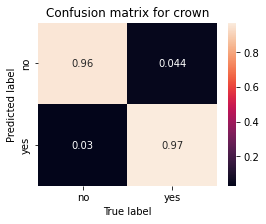

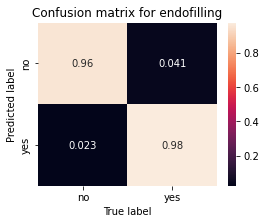

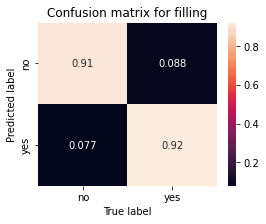

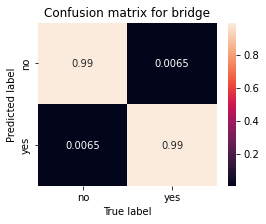

In [ ]:

for attr in attrs:
  y_pred = []
  y_true = []

  was_training = trained_models[attr].training
  trained_models[attr].eval()

  with torch.no_grad():
  # iterate over test data
    for inputs, labels in dataloaders[attr]['val']:
            inputs = inputs.to(device)
            outputs = trained_models[attr](inputs) # Feed Network

            #output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            outputs = (torch.max(outputs, 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

            

            # for j in range(inputs.size()[0]):
            #     ax.set_title('predicted: {}'.format(class_names[attr][preds[j]]))
            #     imshow(inputs.cpu().data[j])
  
  trained_models[attr].train(mode=was_training)

  # constant for classes
  classes = ('no', 'yes')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.reshape(np.sum(cf_matrix, axis=1), (2,1)), index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (4,3))
  sn.heatmap(df_cm, annot=True)
  plt.title(f'Confusion matrix for {attr}')
  plt.xlabel('True label')
  plt.ylabel('Predicted label')
  plt.savefig(f'{dir_prefix}/graphics/binary-{attr}-model.png', dpi=1000)